In [1]:
import numpy as np
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.datasets import make_blobs

# 【問題1】K-meansクラスの作成

In [219]:
import numpy as np

class ScratchKMeans():
    """
    K-meansのスクラッチ実装

    Parameters
    ----------
    num_iter : int
        イテレーション数
    n_clusters
        クラスタ数
    n_init
        k-meansを行う回数
    cluster_centers_
        クラスタの中心の値を格納した配列
        
    Attributes
    ----------
    self.loss : 次の形のndarray, shape (self.iter,)
      学習用データに対する損失の記録
    """

    
    def __init__(self, num_iter=200, n_clusters=8, n_init=10, tolerance=1e-5):
        # ハイパーパラメータを属性として記録
        self.iter = num_iter
        # クラスタ数
        self.n_clusters = n_clusters
        # k-meansを行う回数
        self.n_init = n_init
        # 誤差の許容値
        self.tolerance = tolerance
        # Xのデータ格納用
        self.X_n_features = None
        self.X_n_samples = None
        # クラスタの中心値格納用
        self.cluster_centers_ = None
        # 各Xのラベル格納用
        self.labels_ = None
        # sse格納用
        self.inertia_ = None
        

    def fit(self, X):
        """
        kmeansを学習する。
        
          Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            学習用データの特徴量
        """
        
        # 次元数を必要に応じて追加
        if X.ndim < 2:
            X = X[:, np.newaxis]
        
        # Xの情報をインスタンス変数へ
        self.X_n_samples = X.shape[0]
        self.X_n_features = X.shape[1]
        
        for i in range(self.n_init):
            # 設定されたクラスタ数に応じて、座標の初期化
            cluster_centers = X[np.random.choice(self.X_n_samples, self.n_clusters, replace=False), :]
            # 前ラベル格納用
            ex_labels = np.zeros(self.X_n_samples )[:, np.newaxis]
            
            for j in range(self.iter):
                # クラスタを作成するためにラベリング
                labels = self.label_by_euclidean_distance(X, cluster_centers)[:, np.newaxis]
                
                # ラベルに応じてクラスタを作成し、重心を求める
                gravities = self.calc_gravities(X, labels)
                
                # 中心点と重心の差が指定した許容値以下になるorラベルが変化しなくなるまで中心点を更新
                if  np.abs(np.sum(gravities - cluster_centers)) > self.tolerance or np.allclose(labels, ex_labels):
                    cluster_centers = gravities
                    ex_labels = labels
                else:
                    break
                
            # 目的関数コール
            sse = SSE(X, cluster_centers, labels)
            
            # ループ初回orSSEが低かったら、クラスタの中心を更新
            if i == 0 or self.inertia_ > sse:
                self.cluster_centers_ = cluster_centers
                self.inertia_ = sse
            
            
    def label_by_euclidean_distance(self, X, cluster_centers):
        """
        ユークリッド距離の計算結果に基づいて、ラベリングする
            
        Returns
        -------
         labels: 次の形のndarray, shape (n_samples, 1)
            n_samples数分ラベリングした配列
        """

        #  距離データ格納用
        e_distances = np.empty((0, self.X_n_samples), int)
        
        for i in range(self.n_clusters):
            # 距離を計算し配列に格納
            e_distance = np.linalg.norm(X - cluster_centers[i], axis=1)
            e_distances = np.append(e_distances, np.array([e_distance]), axis=0)
        
        # 配列のうち最小値となる特徴量のラベルを取得
        labels = np.argmin(e_distances, axis=0)

        return labels


    def calc_gravities(self, X, label):
        """
       ラベルを元にクラスタの重心を求める

        Parameters
        ----------
        label : 次の形のndarray, shape (1, n_samples)
            クラスタのラベル
            
        Returns
        -------
        gravities: 次の形のndarray, shape (n_clusters, n_features)
            更新後のクラスタの重心
        """
        
        gravities = np.zeros((self.n_clusters, self.X_n_features))
                               
        for i in range(self.n_clusters):
            cluster_index = np.where(label == i)[0]
            cluster = X[cluster_index, :]
            
            gravities[i] = np.sum(cluster, axis=0) / len(cluster)
            
        return gravities
        
        
    def predict(self, X):
        """
        SVM分類器を使い推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            線形回帰による推定結果
        """
        
        y_pred = self.label_by_euclidean_distance(X, self.cluster_centers_)
        
        return y_pred

In [220]:
import numpy as np

def SSE(X, cluster_centers, labels):
    sse = 0
    for label in np.unique(labels):
        cluster_index = np.where(labels == label)[0]
        sse += np.linalg.norm(X[cluster_index, :] - cluster_centers[label]) ** 2
        
    return sse
    

In [221]:
X, _ = make_blobs(n_samples=100, n_features=2, centers=4, cluster_std=0.5, shuffle=True, random_state=0)

n_clusters = 4

skm = ScratchKMeans(n_clusters=n_clusters)
skm.fit(X)

y_pred = skm.predict(X)

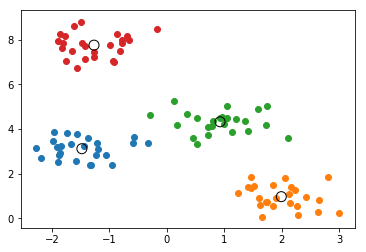

In [222]:
# 各要素をラベルごとに色付けして表示する
for i in range(n_clusters):
    labels = X[y_pred == i]
    plt.scatter(labels[:, 0], labels[:, 1])
    
centers = skm.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], s=100,
            facecolors='none', edgecolors='black')

# 【問題2】エルボー法の実装

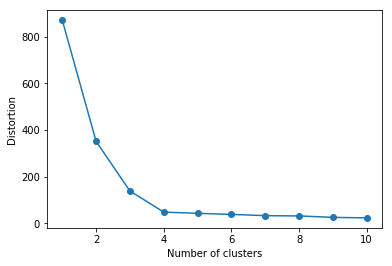

In [223]:
distortions = []

for i  in range(1,11):                # 1~10クラスタまで一気に計算 
    skm = ScratchKMeans(n_clusters=i)
    skm.fit(X)
    distortions.append(skm.inertia_)   # skm.fitするとskm.inertia_が得られる

plt.plot(range(1,11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

# 【問題3】（アドバンス課題）シルエット図

In [ ]:
from matplotlib import cm

y_ax_lower, y_ax_upper = 0, 0
yticks = []
for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y_km == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(i / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, edgecolor='none', color=color)
    yticks.append((y_ax_lower + y_ax_upper) / 2)
    y_ax_lower += len(c_silhouette_vals)

plt.axvline(silhouette_avg, color="red", linestyle="--")
plt.yticks(yticks, cluster_labels + 1)
plt.ylabel('Cluster')
plt.xlabel('Silhouette coefficient')
plt.show()